# Dependencies

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sb
import networkx as nx
import netwulf as wulf
import datetime as dt
import shifterator as sh
import nltk
import re
import random
import json
import community

from wordcloud import WordCloud
from networkx.readwrite import json_graph
from collections.abc import Iterable
from collections import Counter
from scipy import stats
from tfidf import term_frequency, inverse_document_frequency, tf_idf

from data import get_master_dict

from IPython.display import clear_output

# Data preprocessing

A document in the corpus is 'General course objectives' + 'Learning objectives' + 'Content'.

## Load data

In [2]:
courses = pd.DataFrame.from_dict(get_master_dict(), orient='index')

courses['ects'] = courses['ects'].str.replace(',', '.').astype(float)
courses['description'] = courses['description'].str.replace('\r\n', ' ')
courses['department'] = courses['department'].str.replace('\r\n', ' ')
courses['responsible'] = courses['responsible'].str.replace('\r\n', ' ')
courses['co-responsible'] = courses['co-responsible'].str.replace('\r\n', ' ')
courses['type'] = courses['type'].str.replace('Offered as a single course', '')

courses.head()

,description,language,ects,type,location,evaluation,prerequisites,responsible,department,grades,reviews,name,passpercent,avg,pp,avgp,qualityscore,workload,lazyscore,co-responsible
62103,General course objectives To give the students...,Danish,5.0,BEng,Campus Ballerup,"7 step scale , external examiner","62094 , 62094 Introduction to Managerial\r\nEc...","Niels Christian Kjærsgaard , Ballerup Campus,...",62 Department of Engineering Technology and D...,"{'-3': '0', '00': '7', '02': '5', '4': '6', '7...","[{'participants': 30, 'timestamp': 'E21', '1.1...",Managerial Economics and Basic Accounts Analysis,72.0,6.4,51.7,43.8,6.6,31.4,14.1,NaN
02441,General course objectives To acquaint the part...,English,5.0,MSc,Campus Lyngby,"7 step scale , internal examiner","02402 /\r\n02403 /\r\n02323 , An introductory ...","Andreas Baum , andba@dtu.dk",01 Department of Applied Mathematics and Comp...,"{'-3': '0', '00': '0', '02': '5', '4': '9', '7...","[{'participants': 31, 'timestamp': ' 22', '1.1...",Anvendt statistik og statistisk programmel,96.0,7.9,93.1,59.4,48.7,13.6,32.5,"Lasse Engbo Christiansen , laec@dtu.dk"
62l01,General course objectives It is the aim that t...,Danish,10.0,Deltidsdiplom,Campus Ballerup,"7 step scale , external examiner",NaN,"Isa Keller-Andreasen , Ballerup Campus, Build...",62 Department of Engineering Technology and D...,"{'-3': '0', '00': '0', '02': '1', '4': '2', '7...",NaN,Det personlige lederskab og forandring,100.0,8.2,100.0,62.5,NaN,NaN,NaN,NaN
26127,General course objectives To gain experimental...,English,5.0,BScMSc,Campus Lyngby,"pass / not pass , internal examiner",26006.26124,"Kasper Steen Pedersen , Lyngby Campus, Buildi...",26 Department of Chemistry,{},"[{'participants': 1, 'timestamp': ' 21', '1.1'...",Eksperimentel uorganisk kemi,100.0,NaN,100.0,NaN,NaN,NaN,NaN,"Martin Nielsen , Building 206 , marnie@kemi.d..."
41691,General course objectives The PhD student shou...,English,5.0,"Ph.D., Professionally focussed course",Campus Lyngby,"pass / not pass , internal examiner","M.Sc. in Physics, Chemistry, Mathematics or\r\...","Wolfgang Pantleon , Lyngby Campus, Building 4...",41 Department of Mechanical Engineering,{},"[{'participants': 7, 'timestamp': 'F21', '1.1'...",Ph.D. kursus om anvendelse af røntgendiffrakti...,100.0,NaN,100.0,NaN,1.8,41.7,65.0,"Karen Pantleon , Lyngby Campus, Building 425,..."


In [3]:
departments = courses.groupby('department').agg({'description': 'sum', 'ects': 'mean', 'avg': 'mean'})
departments.head()

,description,ects,avg
department,,,
01 Department of Applied Mathematics and Computer Science,General course objectives To acquaint the part...,5.804878,7.973864
"42 Department of Technology, Management and Economics",General course objectives The aim of the modul...,4.966346,9.017284
62 Department of Engineering Technology and Didactics,General course objectives To give the students...,6.686644,8.107955
10 Department of Physics,General course objectives Today it is possible...,6.300000,7.911628
11 Department of Civil Engineering,General course objectives Void Learning objec...,6.036585,7.234579


# Data exploration

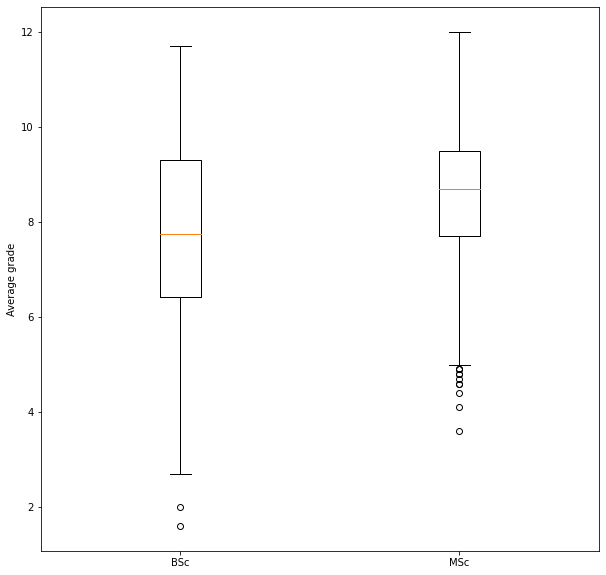

In [4]:
bsc_grades, msc_grades = courses['avg'][courses['type'] == 'BSc'].dropna(), courses['avg'][courses['type'] == 'MSc'].dropna()

fig, ax = plt.subplots(figsize=(10, 10))
ax.boxplot((bsc_grades, msc_grades))
ax.set_xticklabels(('BSc', 'MSc'))
_ = ax.set_ylabel('Average grade')


# Corpus preprocessing

## Tokenizer

In [5]:
# Stop words are removed from the tokenized text. We get the stop words here.
stop_words = set(nltk.corpus.stopwords.words('english'))
stop_words = stop_words.union(
    set(('versionsee', 'danish', 'general', 'course', 
         'learning', 'able', 'met', 'student', 'learning', 'objectives', 
         'content', 'dk', 'kurser', 'https', 'toolsapply'))
)
stop_words = [re.sub('[^a-z_-]', '', stop_word) for stop_word in stop_words]

def tokenize(text: str) -> list[str]:
    """Tokenizer function. 
    The following is removed from the tokenized text:
    Symbols, stop words.
    
    Finally, only unique words are included in the tokens (ie. no repeats)"""
    text = text.lower()
    text = re.sub('[^a-z]', ' ', text)
    tokens = nltk.word_tokenize(text)
    tokens = [word for word in tokens if word not in stop_words and len(word) > 1 and 'void' not in word]
   
    return tokens

In [6]:
# The tokenized text is saved in a new column
departments['tokens'] = departments.apply(lambda row: tokenize(row['description']), axis=1)
courses['tokens'] = courses.apply(lambda row: tokenize(row['description']), axis=1)
courses.head()

,description,language,ects,type,location,evaluation,prerequisites,responsible,department,grades,...,name,passpercent,avg,pp,avgp,qualityscore,workload,lazyscore,co-responsible,tokens
62103,General course objectives To give the students...,Danish,5.0,BEng,Campus Ballerup,"7 step scale , external examiner","62094 , 62094 Introduction to Managerial\r\nEc...","Niels Christian Kjærsgaard , Ballerup Campus,...",62 Department of Engineering Technology and D...,"{'-3': '0', '00': '7', '02': '5', '4': '6', '7...",...,Managerial Economics and Basic Accounts Analysis,72.0,6.4,51.7,43.8,6.6,31.4,14.1,NaN,"[give, students, knowledge, company, internal,..."
02441,General course objectives To acquaint the part...,English,5.0,MSc,Campus Lyngby,"7 step scale , internal examiner","02402 /\r\n02403 /\r\n02323 , An introductory ...","Andreas Baum , andba@dtu.dk",01 Department of Applied Mathematics and Comp...,"{'-3': '0', '00': '0', '02': '5', '4': '9', '7...",...,Anvendt statistik og statistisk programmel,96.0,7.9,93.1,59.4,48.7,13.6,32.5,"Lasse Engbo Christiansen , laec@dtu.dk","[acquaint, participants, statistical, work, pr..."
62l01,General course objectives It is the aim that t...,Danish,10.0,Deltidsdiplom,Campus Ballerup,"7 step scale , external examiner",NaN,"Isa Keller-Andreasen , Ballerup Campus, Build...",62 Department of Engineering Technology and D...,"{'-3': '0', '00': '0', '02': '1', '4': '2', '7...",...,Det personlige lederskab og forandring,100.0,8.2,100.0,62.5,NaN,NaN,NaN,NaN,"[aim, acquires, knowledge, skills, competencie..."
26127,General course objectives To gain experimental...,English,5.0,BScMSc,Campus Lyngby,"pass / not pass , internal examiner",26006.26124,"Kasper Steen Pedersen , Lyngby Campus, Buildi...",26 Department of Chemistry,{},...,Eksperimentel uorganisk kemi,100.0,NaN,100.0,NaN,NaN,NaN,NaN,"Martin Nielsen , Building 206 , marnie@kemi.d...","[gain, experimental, insight, modern, advanced..."
41691,General course objectives The PhD student shou...,English,5.0,"Ph.D., Professionally focussed course",Campus Lyngby,"pass / not pass , internal examiner","M.Sc. in Physics, Chemistry, Mathematics or\r\...","Wolfgang Pantleon , Lyngby Campus, Building 4...",41 Department of Mechanical Engineering,{},...,Ph.D. kursus om anvendelse af røntgendiffrakti...,100.0,NaN,100.0,NaN,1.8,41.7,65.0,"Karen Pantleon , Lyngby Campus, Building 425,...","[phd, obtain, theoretical, knowledge, possibil..."


# TF-IDF analysis

## Course corpus

In [7]:
n_tokens = courses['tokens'].apply(lambda x: len(x))

# Create a corpus wich is a dictionary of the tokenized texts
corpus = courses['tokens'][n_tokens > 30].to_dict()

### Identifying course topics
We can use TF-IDF to sort the tokens in each course description by relevancy. Next, we take the all terms that are above the 90% percentile TF-IDF.

In [8]:
# Get a lookup table for the idf of each term in the corpus.
idf_lookup = inverse_document_frequency(corpus)
print(f"Number of unique terms in the corpus: {len(idf_lookup)}")

Number of unique terms in the corpus: 20240


We calibrate the percentile based on some familiar courses. The calibration is done qualitatively, ie. we look and see if the topics make sense. Additionally, Advanced Engineering Mathematics 1 (010015) has the largest amount of topics among these examples since it is the largest course (covers the most topics). This property is desirable compared to simply choosing the top $x$ terms.

In [9]:
course_topics = {}
for course, document in corpus.items():
    tfidf, terms = tf_idf(document, idf_lookup)
    # sorted_indices = np.argsort(tfidf)[::-1]
    # tfidf = tfidf[sorted_indices]
    # terms = terms[sorted_indices]
    mean, sd = tfidf.mean(), tfidf.std()
    topic_indices = tfidf >= np.percentile(tfidf, 91)
    topics = terms[topic_indices]
    if topics.size:
        course_topics[course] = topics

In [10]:
calibration_courses = ('01005', '02467', '02456', '46500')

for course in calibration_courses:
    print(f'Course:\t{course}')
    print(f'Topics:\t{course_topics[course]}\n')

Course:	01005
Topics:	['mathematics' 'thematic' 'linear' 'equations' 'spaces' 'elementary'
 'functions' 'taylor' 'integrals' 'gauss' 'stokes' 'maple']

Course:	02467
Topics:	['network' 'text' 'social' 'media' 'data' 'visualization' 'metrics'
 'networks' 'communities' 'exploration' 'variable' 'plots' 'reddit']

Course:	02456
Topics:	['machine' 'improved' 'deep' 'dl' 'recognition' 'neural' 'feed' 'forward'
 'convolutional' 'recurrent' 'networks' 'error' 'back' 'propagation'
 'pytorch' 'week' 'ffnn']

Course:	46500
Topics:	['statistical' 'data' 'wind' 'engineering' 'structural' 'probabilistic'
 'machine' 'measured' 'scada' 'probability' 'distributions' 'calibrate'
 'uncertainty' 'quantification' 'reliability' 'extreme' 'topic'
 'predefined' 'submit']



### Is there a correlation between the course topics and the passing grade?

Now we are prepared to answer one of our main research questions.

In [11]:
# Get the topics and their avg grade.
topic_grades = {}

for course, topics in course_topics.items():
    # If the course does not have an avg grade, we skip it.
    course_avg_grade = courses.loc[course, 'avg']
    if np.isnan(course_avg_grade):
        continue
    
    for topic in topics:
        if topic not in topic_grades:
            topic_grades[topic] = [course_avg_grade]
        else:
            topic_grades[topic].append(course_avg_grade)

Let's look at some examples.

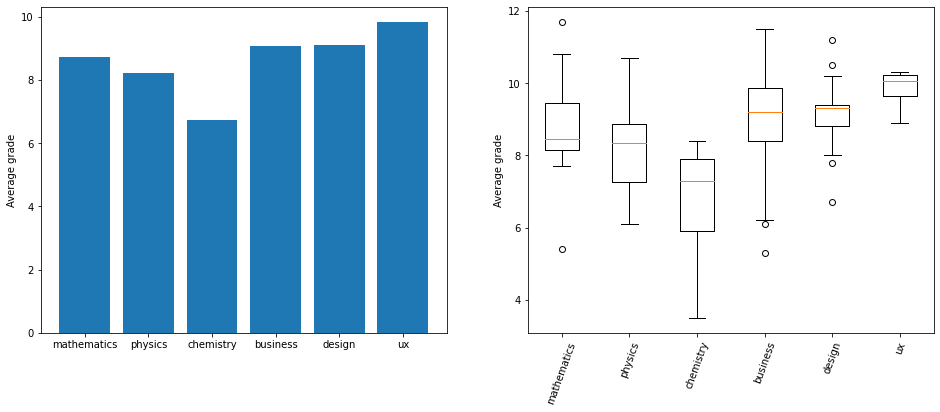

In [12]:
example_topics = ('mathematics', 'physics', 'chemistry', 'business', 'design', 'ux')
mean_avg_grades = [np.mean(topic_grades[topic]) for topic in example_topics]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,6))

ax1.bar(example_topics, [np.mean(topic_grades[topic]) for topic in example_topics])
plt.xticks(rotation=70)
_ = ax1.set_ylabel('Average grade')

ax2.boxplot([topic_grades[topic] for topic in example_topics])
ax2.set_xticklabels(example_topics, rotation=70)
_ = ax2.set_ylabel('Average grade')

Let's do the same things but for all topics!

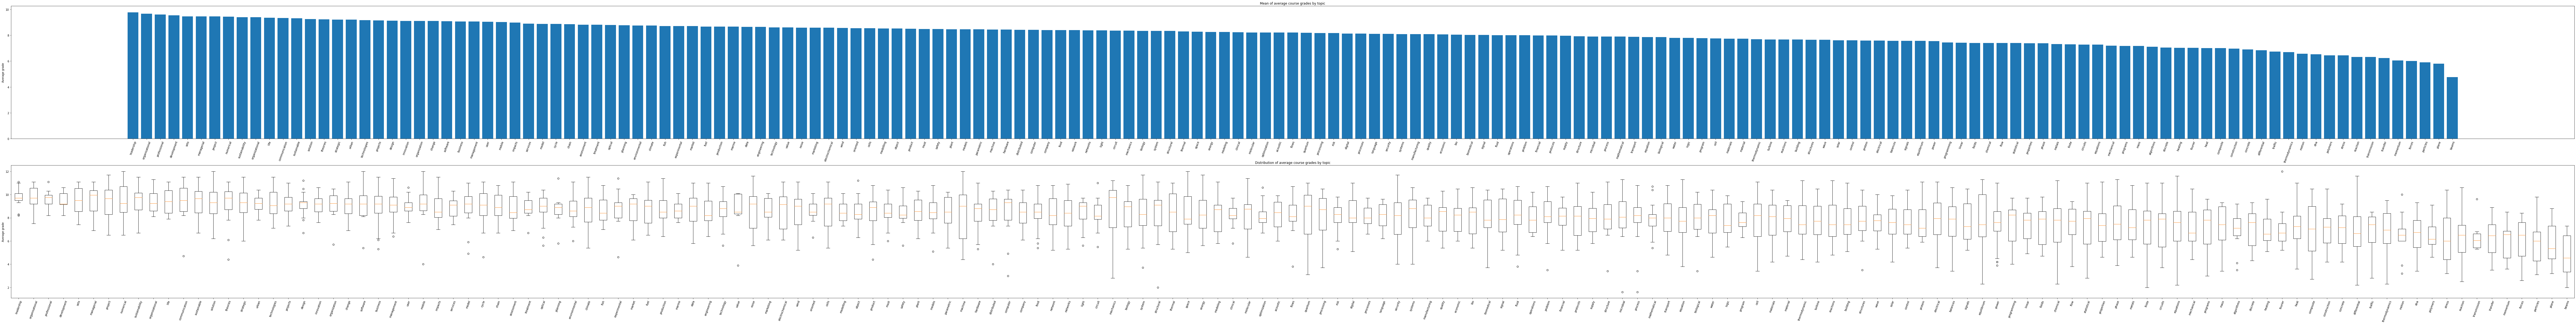

In [13]:
# Filter topics that occur in less than 5 courses
min_appearances = 10

topic_grades_filtered = {topic: avg_grades for topic, avg_grades in topic_grades.items() if len(avg_grades) >= min_appearances}
topic_arr = np.array(list(topic_grades_filtered.keys()))
topic_avg_grades = list(topic_grades_filtered.values())
topic_mean_avg_grades = np.array([np.mean(avg_grades) for avg_grades in topic_avg_grades])
sorted_indices = np.argsort(topic_mean_avg_grades)[::-1]

topic_arr = topic_arr[sorted_indices]
topic_avg_grades = [topic_avg_grades[index] for index in sorted_indices]
topic_mean_avg_grades = topic_mean_avg_grades[sorted_indices]

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(topic_arr.size * 1, 20))

ax1.bar(topic_arr, topic_mean_avg_grades)
ax1.tick_params(axis='x', labelrotation=70)
ax1.set_ylabel('Average grade')
ax1.set_title('Mean of average course grades by topic')

ax2.boxplot(topic_avg_grades)
ax2.set_xticklabels(topic_arr, rotation=70)
ax2.set_ylabel('Average grade')
_ = ax2.set_title('Distribution of average course grades by topic')
plt.savefig('grades_by_topic')

## Department corpus
We can also make a corpus of all course descriptions in a department. We can use TF-IDF to score the terms and create some very nice looking wordclouds, that visualize what each department is about.

In [14]:
# Create a corpus wich is a dictionary of the tokenized texts
corpus = departments['tokens'].to_dict()

In [15]:
idf_lookup = inverse_document_frequency(corpus)

In [16]:
topx = 10

# Top 10 words, TF-IDF
print('Top 10 terms sorted by TF-IDF:')

# for department, document in corpus.items():
#     tfidf, terms = tf_idf(document, idf_lookup)
#     sorted_indices = np.argsort(tfidf)[::-1]
#     top_x_terms = terms[sorted_indices[:topx]]
#     # print(tfidf[sorted_indices[:topx]])
#     print(f'{department}:')
#     print(top_x_terms)

Top 10 terms sorted by TF-IDF:


### Wordclouds

In [17]:
# Generate a word cloud image
# for department, document in corpus.items():
#     tfidf, terms = tf_idf(document, idf_lookup)
#     wc = WordCloud(background_color='white', width=1600, height=800).generate_from_frequencies({term: w for w, term in zip(tfidf, terms)})
    
#     fig, ax = plt.subplots(1, 1, figsize=(18, 9))
#     fig.suptitle(f'{department}', fontsize='xx-large')
#     ax.imshow(wc, interpolation='bilinear')
#     ax.axis('off')
#     plt.show()

# Network analysis

In [18]:
adjacency_dict = {}

n_courses = len(course_topics)
for i, (course, topics) in enumerate(course_topics.items()):
    adjacency_dict[course] = {}
    topics_set = set(topics)
    for other_course, other_topics in course_topics.items():
        if course == other_course:
            continue
        
        num_common = len(topics_set.intersection(other_topics))
        if num_common:
            adjacency_dict[course][other_course] = {'weight': num_common}
    clear_output(wait=True)
    print(i/n_courses)

G = nx.Graph(adjacency_dict)

with open('course_graph.json', 'w') as outfile:
    json.dump(json_graph.node_link_data(G), outfile, indent=8)

0.9993662864385298


In [19]:
with open('course_graph.json') as f:
    G = json_graph.node_link_graph(json.load(f))

In [20]:
n_departments = courses['department'].nunique()

cm = plt.get_cmap('tab20b')
color_linspace = np.linspace(0, 1, num=n_departments)
department_cmap = {department: tuple((np.array(cm(color_linspace[i]))[:3] * 255).astype(int)) for i, department in enumerate(courses['department'].unique())}
department_cmap = {department: (rgb, "#{0:02x}{1:02x}{2:02x}".format(*rgb)) for department, rgb in department_cmap.items()}

for k, v in G.nodes(data=True):
    v['group'] = department_cmap[courses.loc[k, 'department']][1]

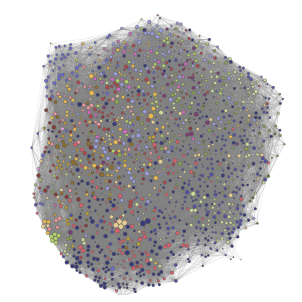

In [21]:
stylized_network, config = wulf.visualize(G)

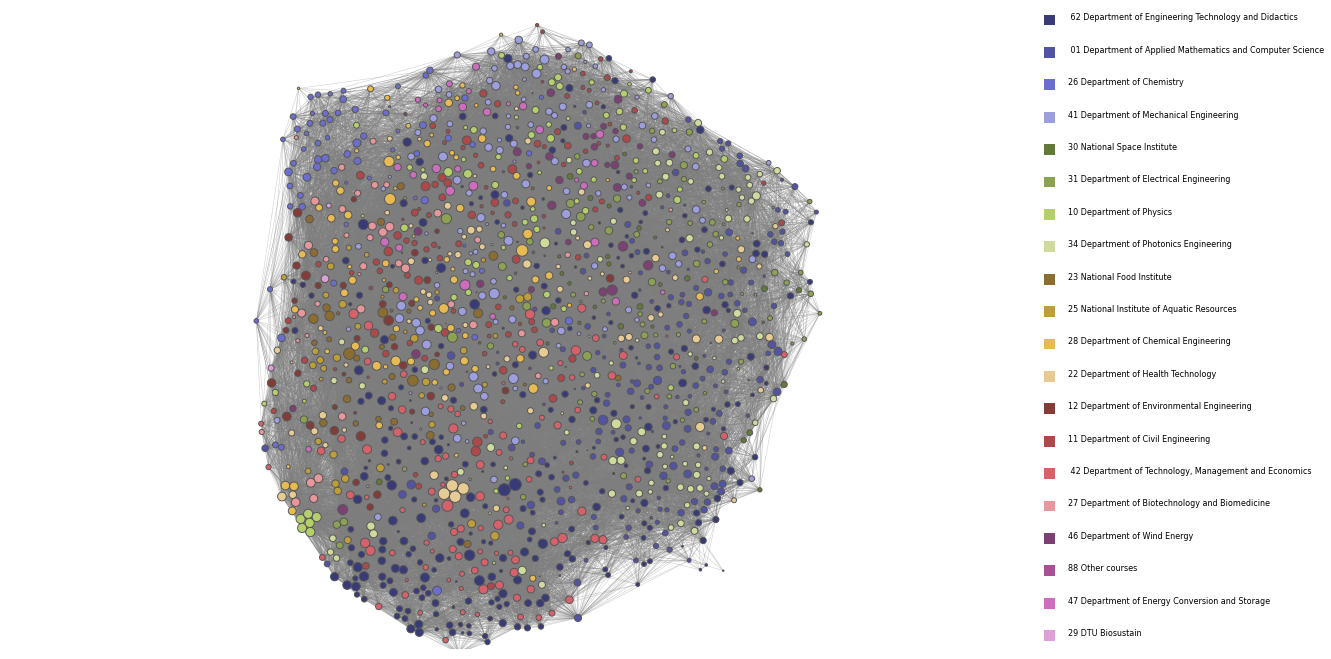

In [22]:
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(18, 9)
subfig1, subfig2 = fig.subfigures(1, 2, wspace=0, width_ratios=(.8, .2))
axs = subfig2.subplots(n_departments, 2)

for i, (department, (rgb, _)) in enumerate(department_cmap.items()):
    ax_color, ax_text = axs[i]
    ax_text.text(0, 0.5, department, dict(size=8))
    ax_color.imshow([[np.array(rgb)/255]])
    ax_text.axis('off')
    ax_color.axis('off')

ax = subfig1.subplots(1, 1)
fig, ax = wulf.draw_netwulf(stylized_network, fig=subfig1, ax=ax)
plt.show()

In [23]:
partition = nx.algorithms.community.louvain_communities(G)
# partition = nx.algorithms.community.greedy_modularity_communities(G)

In [24]:
n_communities = len(partition)

cm = plt.get_cmap('tab20b')
color_linspace = np.linspace(0, 1, num=n_communities)
community_cmap = {i: tuple((np.array(cm(color_linspace[i]))[:3] * 255).astype(int)) for i in range(n_communities)}
community_cmap = {i: (rgb, "#{0:02x}{1:02x}{2:02x}".format(*rgb)) for i, rgb in community_cmap.items()}

for k, v in G.nodes(data=True):
    for i, community in enumerate(partition):
        if k in community:
            break
    v['group'] = community_cmap[i][1]

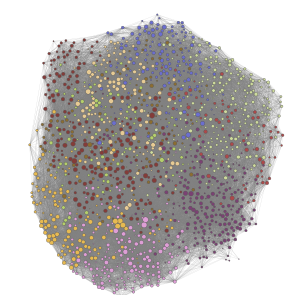

In [25]:
stylized_network, config = wulf.visualize(G)

30110
Fagprojekt - Geofysik og Rumteknologi
reportin, projectprovide, projectinterpret
02362
Projekt i software-udvikling
threadsuse, tablescontent, recursionuse
11995
Designteori og metoder
statementsapply, specificationswork, solutionsachieve
62422
Bio-medical electronics 1
spolerexplain, microcontrollerimplement, microcontrollerdemonstrate
11526
Interdisciplinary Design Project
phasing, managementprofessional, managementoral
ku010
Bevægeapparatets Biomekanik
smtb, ku
46110
Grundlæggende Aerodynamik
wings, lifting, kutta


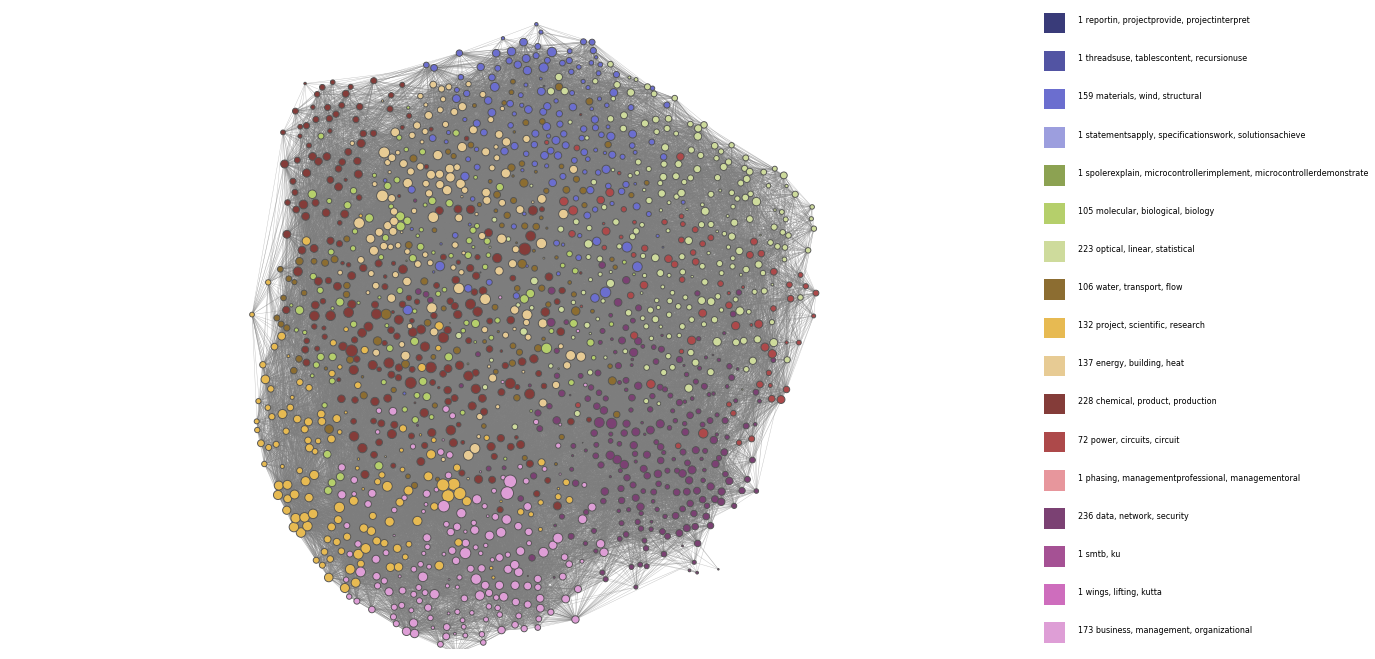

In [35]:
fig = plt.figure(constrained_layout=True)
fig.set_size_inches(18, 9)
subfig1, subfig2 = fig.subfigures(1, 2, wspace=0, width_ratios=(.8, .2))
axs = subfig2.subplots(n_communities, 2)

for i, (rgb, _) in community_cmap.items():
    community = partition[i]
    community_topics = np.array([])
    for course in community:
        community_topics = np.concatenate((community_topics, course_topics[course]))
    topics, counts = np.unique(community_topics, return_counts=True)
    if topics.size:
        sorted_indices = np.argsort(counts)[::-1]
        topics_top3 = list(topics[sorted_indices[:3]])
    ax_color, ax_text = axs[i]
    ax_text.text(0, 0.5, f"{len(community)} {', '.join(topics_top3)}" , dict(size=8))
    ax_color.imshow([[np.array(rgb)/255]])
    ax_text.axis('off')
    ax_color.axis('off')
    # DEBUG
    if len(community) == 1:
        offender = list(community)[0]
        print(offender)
        print(courses.loc[offender, 'name'])
        print(', '.join(topics_top3))

ax = subfig1.subplots(1, 1)
fig, ax = wulf.draw_netwulf(stylized_network, fig=subfig2, ax=ax)
plt.show()

## Jaccard similarity

In [29]:
department2label = {department: index for index, department in enumerate(courses['department'].unique())}

In [50]:
Z = []
Q = []
for index, community in enumerate(partition):
    for course in community:
        Z.append(index)
        Q.append(department2label[courses.loc[course, 'department']])
Z = np.array(Z)
Q = np.array(Q)

N = Z.size
K, M = max(Z) + 1, max(Q) + 1
# Joint count matrix
nkm = np.zeros((max(Z) + 1, max(Q) + 1))
for z in range(K):
    for q in range(M):
        nkm[z, q] = np.sum((Z == z) & (Q == q))
nZ = nkm.sum(1)
nQ = nkm.sum(0)

In [51]:
S = np.sum(nkm * (nkm - 1) / 2)
D = N * (N - 1) / 2 - np.sum(nZ * (nZ - 1) / 2) - np.sum(nQ * (nQ - 1) / 2) + S
J = S / (.5 * N * (N - 1) - D)
J

0.11382560412346594